# Img2Img translation experiments with latent diffusion models & Stable Diffusion pre-training 

# Device

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# must apparently be placed before importing torch?
device = "cuda"

# Imports

In [2]:
import gc
import random
from argparse import Namespace
from datetime import datetime
from math import ceil
from pathlib import Path
from warnings import warn

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import DDIMInverseScheduler, DDIMScheduler
from IPython.core.display import HTML
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

In [3]:
plt.style.use("ggplot")

In [46]:
%load_ext autoreload
%autoreload 3

from src.custom_pipeline_stable_diffusion_img2img import CustomStableDiffusionImg2ImgPipeline
from src.utils_Img2Img_SD import check_Gaussianity, tensor_to_PIL, print_grid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Common params

In [5]:
args = Namespace(resolution=128)

In [6]:
# args.batch_size = 64   # 12GB
# args.batch_size = 128  # 24GB
# args.batch_size = 192  # 32GB
args.batch_size = 256  # 44GB
# args.batch_size = 512    # 80GB

# Base algorithm: Inverse DDIM

From [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/pdf/2105.05233.pdf#appendix.F.)

In order transfer an image to some domain, we need to find the latent that *would* map to that sample.

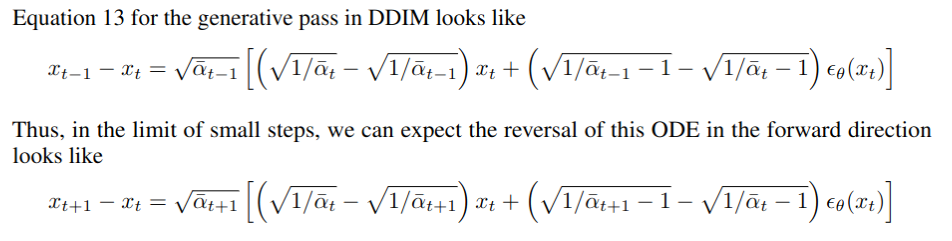

The authors use 250 "reverse" steps (that is, to noise the image? *"reverse"* normally means from Gaussian to data), and only "reverse" the first 249 *(reverse?)* steps.  

## Load pretrained pipeline

In [7]:
pipeline_path = Path("experiments", "cstm_class_cond_test_sparse_embed", "full_pipeline_save")
assert pipeline_path.exists()

In [8]:
pipeline = CustomStableDiffusionImg2ImgPipeline.from_pretrained(pipeline_path, local_files_only=True)
denoiser = pipeline.unet.to(device).eval().requires_grad_(False)
noise_scheduler = pipeline.scheduler
autoencoder = pipeline.vae.to(device).eval().requires_grad_(False)
class_encoder = pipeline.class_embedding.to(device).eval().requires_grad_(False)

## Load dataset info

In [9]:
augmentations = transforms.Compose(
    [
        transforms.Resize(
            args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)

In [10]:
dataset_path = Path(
    "..",
    "..",
    "first-experiments-with-diffusion-models",
    "HF_cstmzd_condgen",
    "data",
    "BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced",
    "train",
)

dataset = ImageFolder(
    root=dataset_path.as_posix(),
    transform=lambda x: augmentations(x.convert("RGB")),
    target_transform=lambda y: torch.tensor(y).long(),
)

# hardcoded per experiment
classes_seen_during_training = ["DMSO", "latrunculin_B_high_conc"]
class_to_index = {"DMSO": 0, "latrunculin_B_high_conc": 1}

## Randomly load samples from specified classes

In [11]:
selected_classes = ["DMSO", "latrunculin_B_high_conc"]
assert all(sel_cl in classes_seen_during_training for sel_cl in selected_classes)

nb_samples_per_class = 5

In [12]:
sel_samples = dict.fromkeys(selected_classes)
for sel_cl in selected_classes:
    sel_samples[sel_cl] = {
        "sample": torch.zeros(
            nb_samples_per_class, 3, args.resolution, args.resolution
        ).to(device),
        "sample_to_show": [None] * nb_samples_per_class,
    }

Samples from DMSO (index 0):


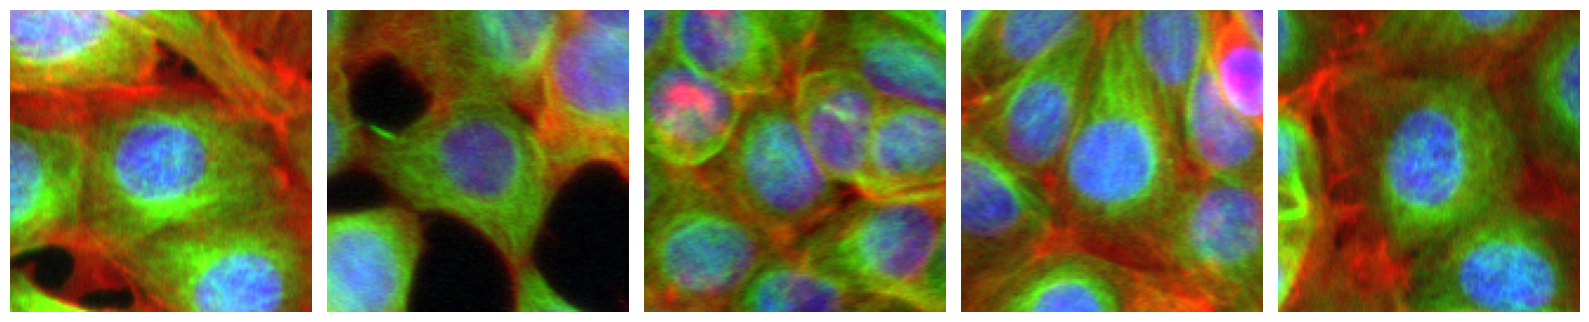

Samples from latrunculin_B_high_conc (index 1):


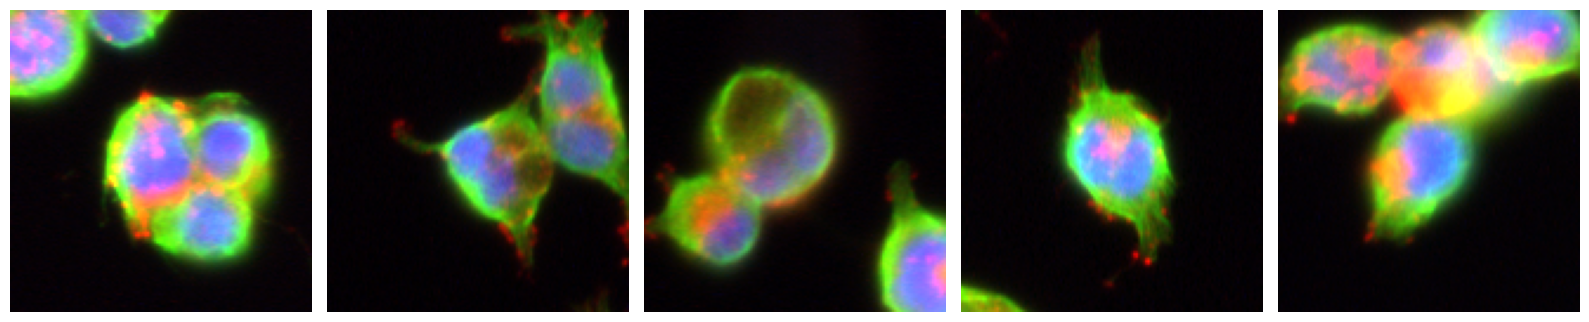

In [13]:
for sel_cl in selected_classes:
    cl_idx = torch.tensor(class_to_index[sel_cl]).long().to(device)
    sel_samples[sel_cl]["class_idx"] = cl_idx
    folder_path = Path(dataset_path, sel_cl)
    list_sample_names = random.sample(os.listdir(folder_path), nb_samples_per_class)
    for idx_sample, sample_name in enumerate(list_sample_names):
        sample_path = Path(folder_path, sample_name)
        sample_to_show = Image.open(sample_path).convert("RGB")
        sample = augmentations(Image.open(sample_path).convert("RGB")).to(device)
        sample.requires_grad_(False)
        sel_samples[sel_cl]["sample"][idx_sample] = sample.clone()
        sel_samples[sel_cl]["sample_to_show"][idx_sample] = sample_to_show
    print(f"Samples from {sel_cl} (index {class_to_index[sel_cl]}):")
    print_grid(sel_samples[sel_cl]["sample_to_show"])

## Get inversed Gaussians

### First encode the images

================================================ DMSO (index 0) ================================================
Original samples:


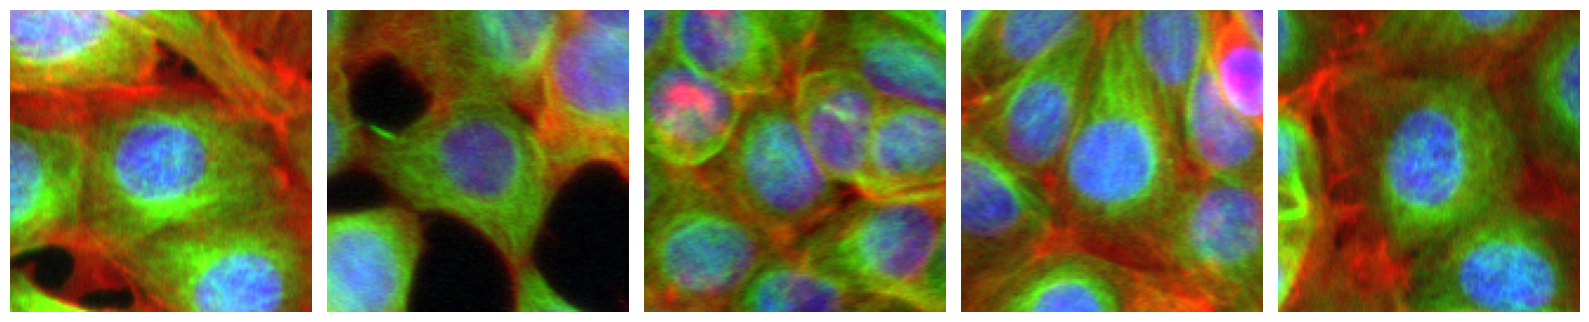

Latents (showing the mean over the 4 channels):


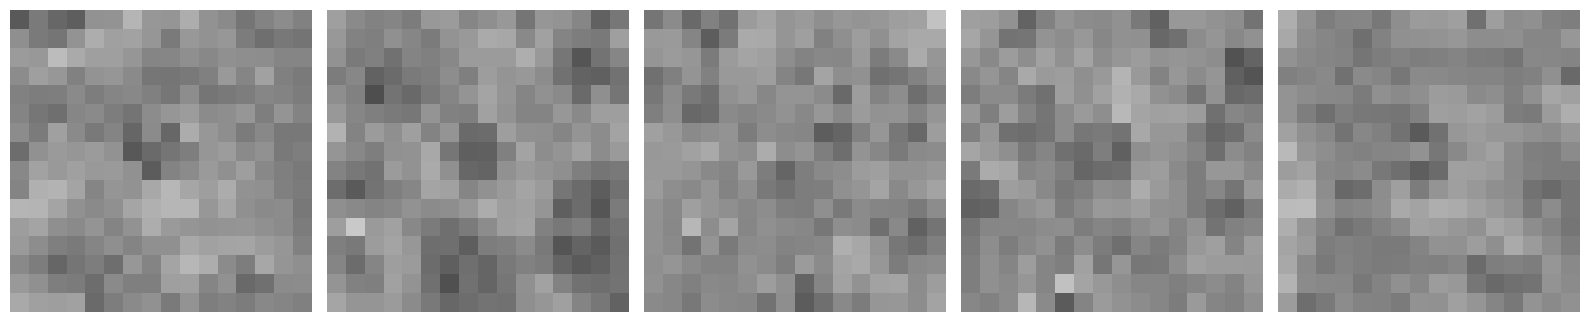

Latents (first 3 channels):


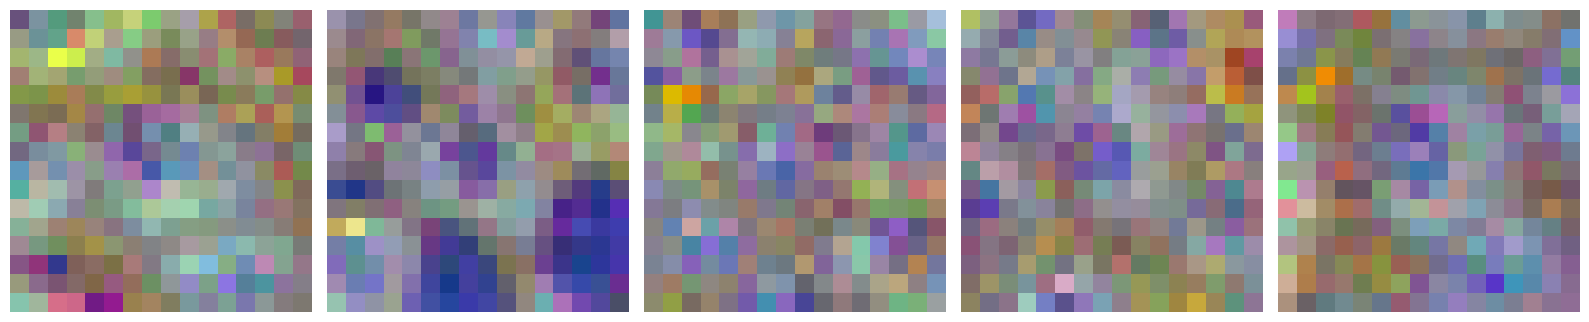

================================================ latrunculin_B_high_conc (index 1) ================================================
Original samples:


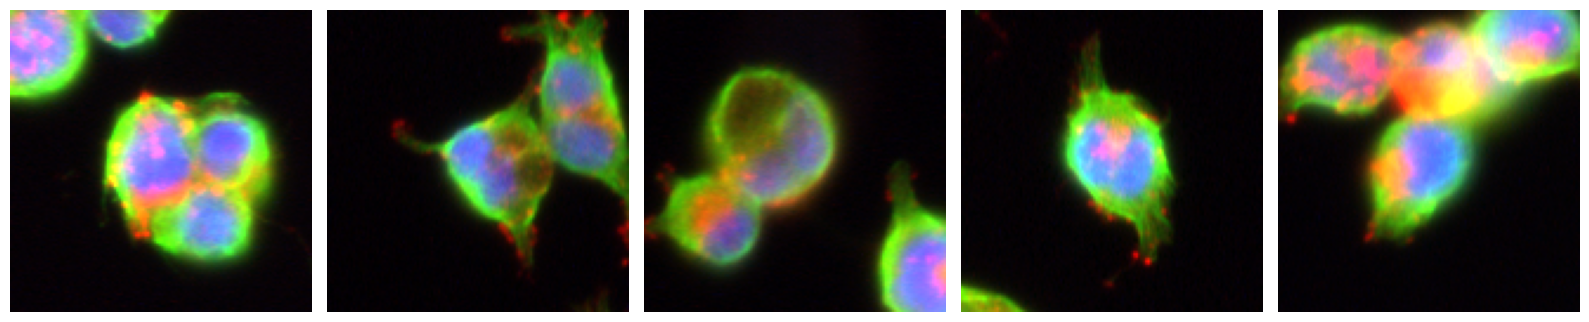

Latents (showing the mean over the 4 channels):


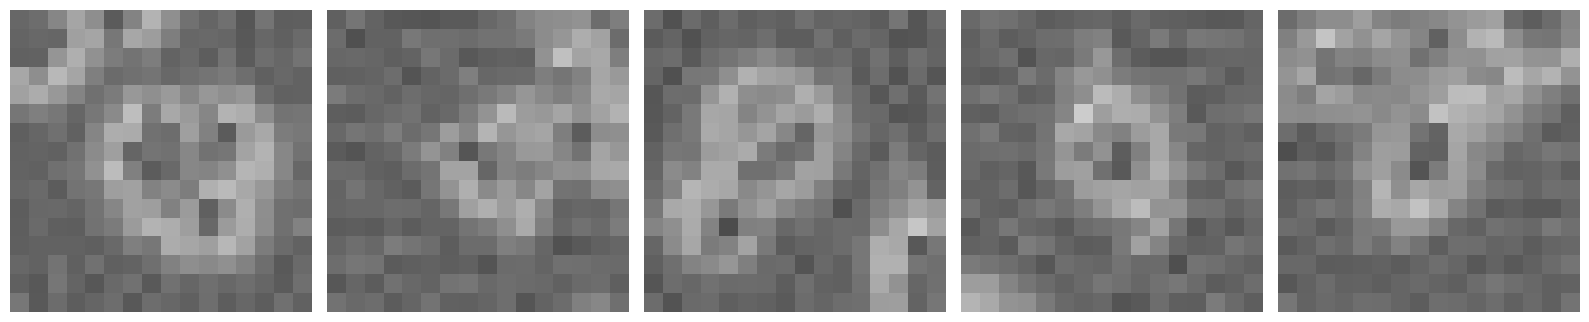

Latents (first 3 channels):


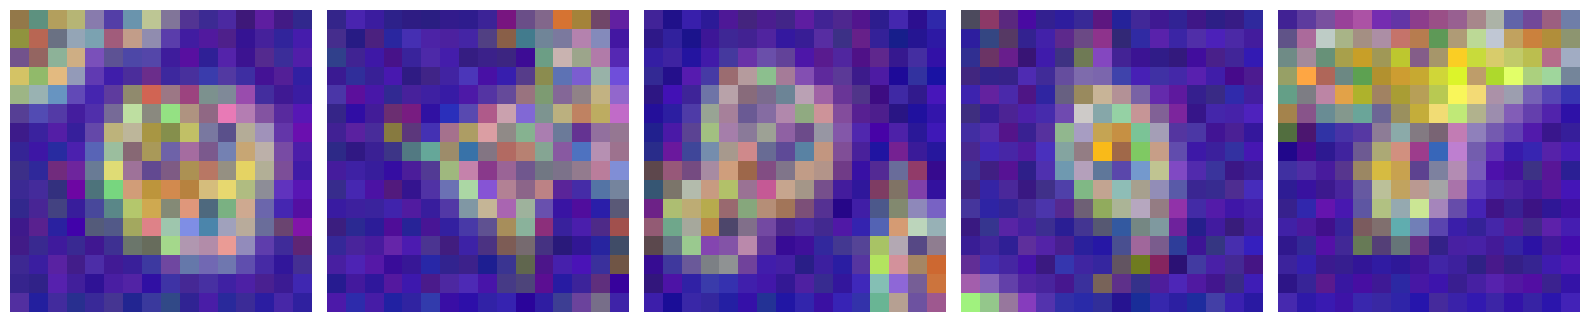

In [42]:
with torch.no_grad():
    for sel_cl in selected_classes:
        sel_samples[sel_cl]["latent"] = autoencoder.encode(sel_samples[sel_cl]["sample"]).latent_dist.sample()
        sel_samples[sel_cl]["latent_to_show_mean"] = tensor_to_PIL(sel_samples[sel_cl]["latent"])
        sel_samples[sel_cl]["latent_to_show_1-3"] = tensor_to_PIL(sel_samples[sel_cl]["latent"], first_3_channels=True)
        print(f"================================================ {sel_cl} (index {class_to_index[sel_cl]}) ================================================")
        print(f"Original samples:")
        print_grid(sel_samples[sel_cl]["sample_to_show"])
        print(f"Latents (showing the mean over the 4 channels):")
        print_grid(sel_samples[sel_cl]["latent_to_show"])
        print(f"Latents (first 3 channels):")
        print_grid(sel_samples[sel_cl]["latent_to_show_1-3"])

### Then perform DDIM inversion

In [24]:
print(f"Number of training steps: {noise_scheduler.timesteps.max().item() + 1}")

Number of training steps: 3000


In [25]:
# higher values give much better results (but take longer)
nb_noising_iter = 3000
# should be in the range [1; scheduler.timesteps.max() + 1] (as scheduler.timesteps starts at zero)
assert nb_noising_iter <= noise_scheduler.timesteps.max().item() + 1

# Essentially, the inversion should follow the exact same discetization
# as the "forward" pass
noise_scheduler.set_timesteps(nb_noising_iter)

inv_scheduler = DDIMInverseScheduler.from_config(noise_scheduler.config)
inv_scheduler.set_timesteps(nb_noising_iter)

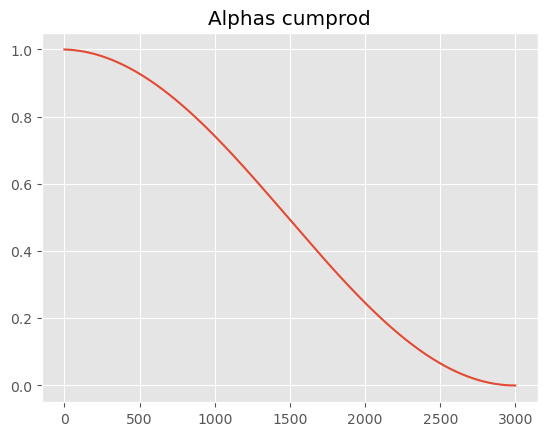

In [26]:
plt.plot(noise_scheduler.alphas_cumprod)
plt.title("Alphas cumprod")
plt.show()

In [27]:
with torch.no_grad():
    for sel_cl in selected_classes:
        # get the latent representation of the sample
        latent = sel_samples[sel_cl]["latent"]
        gauss = latent.clone().detach()

        # get the embedding for this class
        cl_idx = sel_samples[sel_cl]["class_idx"]
        cl_embed = class_encoder(cl_idx).repeat(nb_samples_per_class, 1)

        # hack to match the expected encoder_hidden_states shape
        (bs, ed) = cl_embed.shape
        cl_embed = cl_embed.reshape(bs, 1, ed)
        padding = torch.zeros_like(cl_embed).repeat(1, 76, 1).to(cl_embed.device)
        cl_embed = torch.cat([cl_embed, padding], dim=1)

        for t in tqdm(
            inv_scheduler.timesteps[:-1],
            desc="Inverting latents to Gaussian space...",
            leave=False,
        ):
            model_output = denoiser(gauss, t, encoder_hidden_states=cl_embed).sample

            gauss = inv_scheduler.step(
                model_output,
                t,
                gauss,
            ).prev_sample

        sel_samples[sel_cl]["Gaussian"] = gauss
        sel_samples[sel_cl]["Gaussian_to_show_1-3"] = tensor_to_PIL(gauss, first_3_channels=True)

Inverting latents to Gaussian space...:   0%|          | 0/2999 [00:00<?, ?it/s]

Inverting latents to Gaussian space...:   0%|          | 0/2999 [00:00<?, ?it/s]


################ Inverted Gaussians of latents of DMSO samples (first 3 channels):


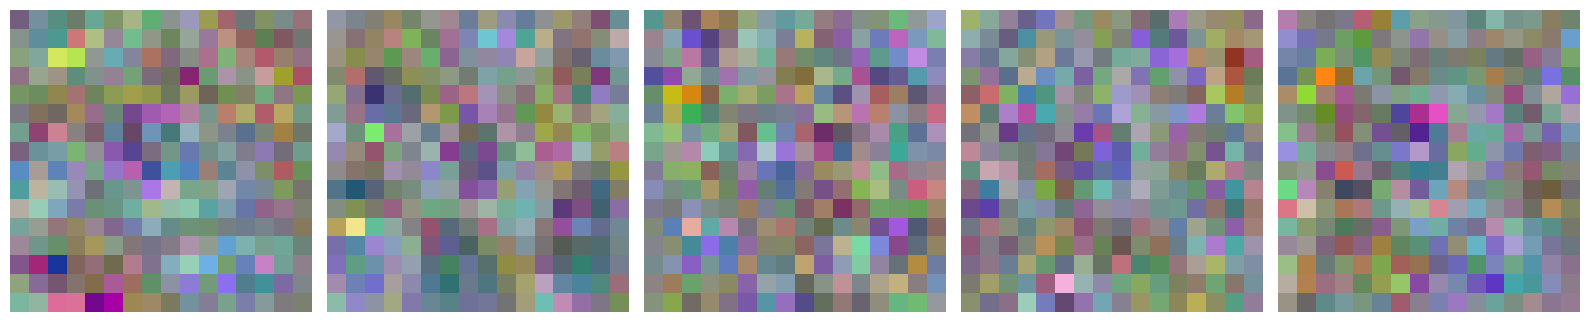

Checking Gausianity of components of tensor of shape (5, 4, 16, 16)...
Gaussian(?) 0: mean=0.006301548331975937, std=0.9929354190826416; 2-sided Χ² probability for the normality hypothesis: 9.470436265662983e-08
Gaussian(?) 1: mean=-0.0234825499355793, std=0.9542475938796997; 2-sided Χ² probability for the normality hypothesis: 0.0034689227224373046
Gaussian(?) 2: mean=0.022789815440773964, std=1.0387158393859863; 2-sided Χ² probability for the normality hypothesis: 0.01619991846988644
Gaussian(?) 3: mean=0.007886974141001701, std=1.025505542755127; 2-sided Χ² probability for the normality hypothesis: 0.0003487612672480652
Gaussian(?) 4: mean=-0.0285223126411438, std=1.001023530960083; 2-sided Χ² probability for the normality hypothesis: 6.559581716682339e-08


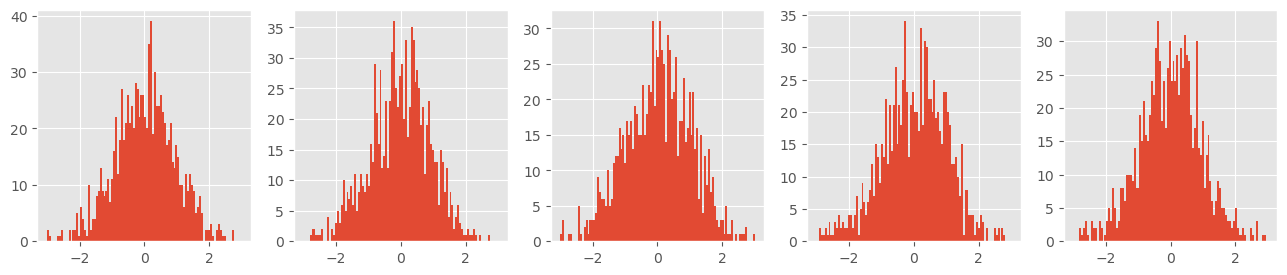


################ Inverted Gaussians of latents of latrunculin_B_high_conc samples (first 3 channels):


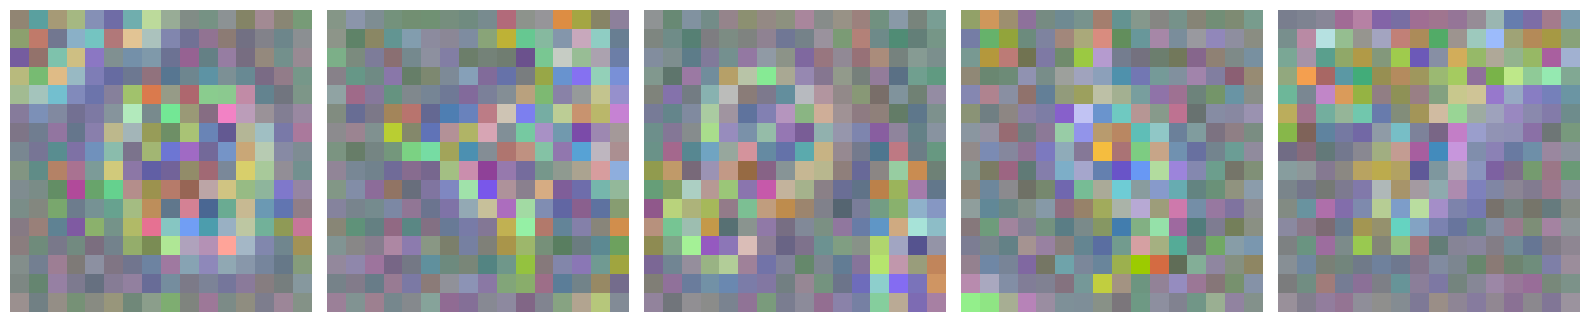

Checking Gausianity of components of tensor of shape (5, 4, 16, 16)...
Gaussian(?) 0: mean=-0.024187462404370308, std=0.981867790222168; 2-sided Χ² probability for the normality hypothesis: 4.214126222595532e-06
Gaussian(?) 1: mean=-0.06073805317282677, std=0.9654148817062378; 2-sided Χ² probability for the normality hypothesis: 1.3464919731233819e-05
Gaussian(?) 2: mean=-0.0432858020067215, std=0.9481419920921326; 2-sided Χ² probability for the normality hypothesis: 0.0005391893017907464
Gaussian(?) 3: mean=-0.0666065514087677, std=0.9555286169052124; 2-sided Χ² probability for the normality hypothesis: 1.619465455395936e-09
Gaussian(?) 4: mean=-0.027382247149944305, std=0.9431385397911072; 2-sided Χ² probability for the normality hypothesis: 0.0059230181251177134


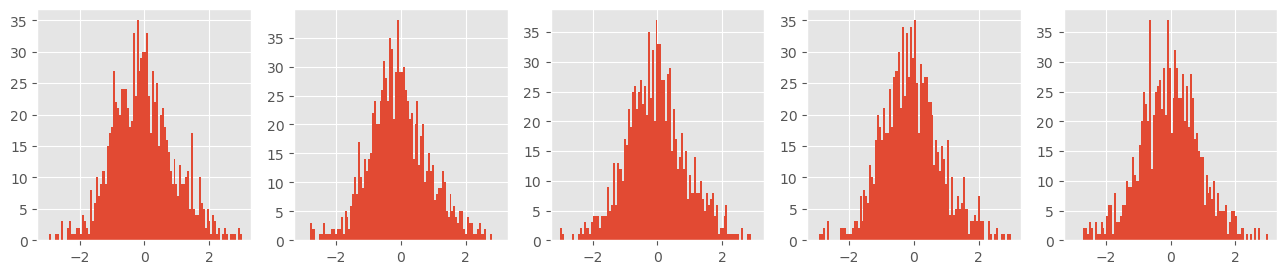

In [47]:
for sel_cl in selected_classes:
    print(f"\n################ Inverted Gaussians of latents of {sel_cl} samples (first 3 channels):")
    print_grid(sel_samples[sel_cl]["Gaussian_to_show_1-3"])
    check_Gaussianity(sel_samples[sel_cl]["Gaussian"])

Gaussianity check per-channel:

Checking Gausianity of components of tensor of shape torch.Size([4, 16, 16])...
latent 0: mean=-0.07827943563461304, std=0.9298513531684875; 2-sided Χ² probability for the normality hypothesis: 0.026433905886458508
latent 1: mean=-0.002388283610343933, std=1.012956142425537; 2-sided Χ² probability for the normality hypothesis: 1.329833060601929e-07
latent 2: mean=0.01607086881995201, std=1.0301377773284912; 2-sided Χ² probability for the normality hypothesis: 0.3230635409544215
latent 3: mean=0.08980304002761841, std=0.9945054650306702; 2-sided Χ² probability for the normality hypothesis: 1.6645744833008006e-07


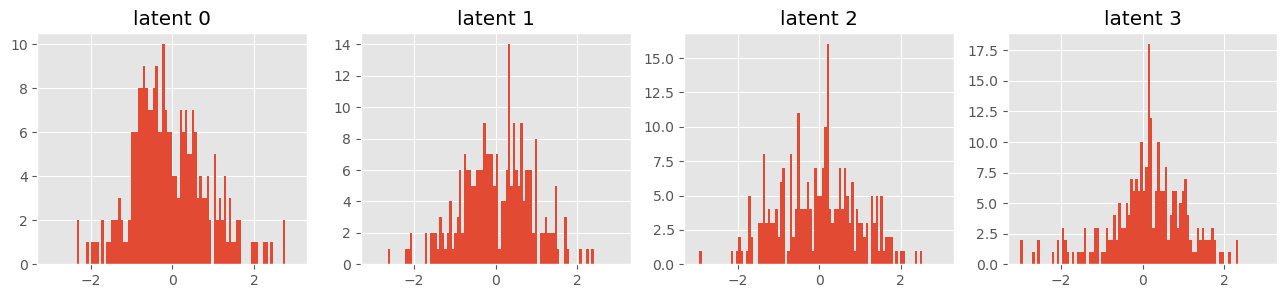

In [29]:
check_Gaussianity(sel_samples["DMSO"]["Gaussian"][0])

The latents "are never Gaussian"!

For reference:

Checking Gausianity of components of tensor of shape torch.Size([5, 4, 16, 16])...
latent 0: mean=-0.00666310079395771, std=0.9578867554664612; 2-sided Χ² probability for the normality hypothesis: 0.8344281383618067
latent 1: mean=0.07114778459072113, std=0.9793435335159302; 2-sided Χ² probability for the normality hypothesis: 0.9895585785625687
latent 2: mean=0.01489398255944252, std=0.9925841689109802; 2-sided Χ² probability for the normality hypothesis: 0.4605960164445454
latent 3: mean=0.014113234356045723, std=0.9875819087028503; 2-sided Χ² probability for the normality hypothesis: 0.21159382065981583
latent 4: mean=0.022620555013418198, std=1.01718008518219; 2-sided Χ² probability for the normality hypothesis: 0.18812015511809452


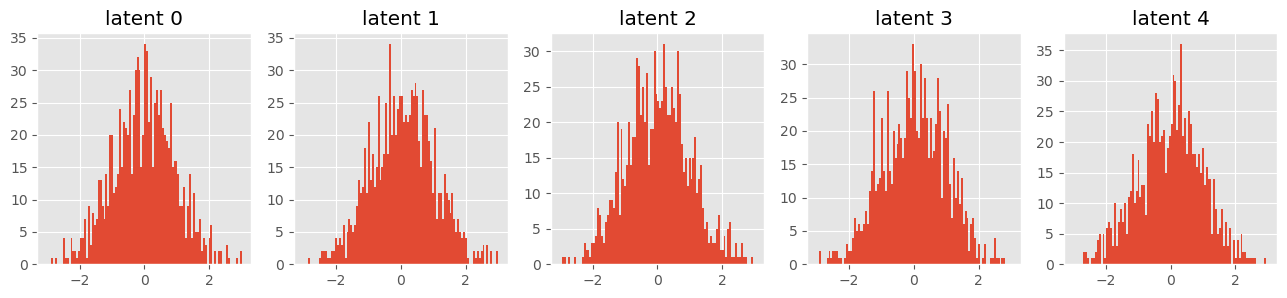

In [30]:
latent = torch.randn_like(sel_samples[sel_cl]["Gaussian"])
check_Gaussianity(latent)

Note that the test is quite inappropriate to our setting as `scipy.stats.normaltest` performs the test on the flattened array: any spatial struture is thus lost. It appears that high concentrations images with an important foreground-background delta 

## Regenerate

In [ ]:
with torch.no_grad():
    for sel_cl in selected_classes:
        # get the Gaussian of the latents
        inv_latent = sel_samples[sel_cl]["Gaussian"]
        inv_latent = latent.clone().detach()

        # get the embedding for this class
        cl_idx = sel_samples[sel_cl]["class_idx"]
        cl_embed = class_encoder(cl_idx).repeat(nb_samples_per_class, 1)

        # hack to match the expected encoder_hidden_states shape
        (bs, ed) = cl_embed.shape
        cl_embed = cl_embed.reshape(bs, 1, ed)
        padding = torch.zeros_like(cl_embed).repeat(1, 76, 1).to(cl_embed.device)
        cl_embed = torch.cat([cl_embed, padding], dim=1)

        for t in tqdm(
            noise_scheduler.timesteps, desc="Regenerating latent vector...", leave=False
        ):
            model_output = denoiser(
                inv_latent, t, encoder_hidden_states=cl_embed
            ).sample

            inv_latent = noise_scheduler.step(
                model_output,
                t,
                inv_latent,
            ).prev_sample

        sel_samples[sel_cl]["inv_latent"] = inv_latent
        sel_samples[sel_cl]["inv_latent_to_show_1-3"] = tensor_to_PIL(inv_sample, pipeline)

Let's assess and compare the inversion performance:

In [ ]:
for sel_cl in selected_classes:
    print_grid(
        sel_samples[sel_cl]["sample_to_show"]
        + sel_samples[sel_cl]["inv_sample_to_show"]
    )
    for idx in range(nb_samples_per_class):
        diff = torch.linalg.norm(
            sel_samples[sel_cl]["inv_sample"][idx] - sel_samples[sel_cl]["sample"][idx]
        ).item()
        print(f"L2 reconstruction error: {diff}")

Sometimes rather close but still quite different... 

TODO: inquire about these inversion punctual artifacts 

For "reference":

In [ ]:
torch.linalg.norm(torch.randn_like(sample[0]) - torch.randn_like(sample[0])).item()

# Linear interpolation along classes embeddings with custom guidance

In the absence of a *specifically enforced* structured class embedding space, a *meaningful* linear interpolation between class embeddings seems hopeless. This is not quite what is observed, however! Why? $\rightarrow$ TODO: research why `nn.Embedding` behaves nicely.

Nevertheless, there is simply no reason that samples positioned along a linear path in class embedding space should be close to each other in any way (try below with `guidance_loss_scale=0`).

$\rightarrow$ **We need to guide the generation process so that *some attributes* of the original image remain invariant along the class embedding interpolation.**

For now let's try to use a simple $L_p$ norm between the original image $x_0$ and the would-be generated one $\hat{x}_0$ as a guidance signal for the diffusion process. 

Of course a decently performant version would:
* force a meaningfull linear interpolation in class embedding space during training of this embedding (*e.g.* using intermediary drug concentrations) ; note that the linear interpolation seems –quite weirdly– to behave quite well already
* use a more advanced external model to capture these attributes we want to preserve 

Note that this could also be done trivially without interpolation, directly giving the full target class embedding.

## Guidance loss

In [ ]:
def Lp_loss(
    x: torch.Tensor, y: torch.Tensor, p: int | float | Literal["inf", "-inf"] = 2
) -> torch.Tensor:
    """Returns the L_p norms of the flattened `(x[i] - y)` vectors for each `i` in the batch.

    Arguments
    ---------
    - x: `torch.Tensor`, shape `(N, C, H, W)`
    - y: `torch.Tensor`, shape `(C, H, W)`
    - p: `int | float | "inf" | "-inf"`, default `2`

    Returns
    -------
    `torch.linalg.vector_norm(x - y, dim=(1, 2, 3), ord=p)`, that is:
    ```
        torch.linalg.vector_norm(x[i] - y, ord=p) for i in range(N)
    ```
    """
    assert x.shape[1:] == y.shape, f"x.shape = {x.shape} != {y.shape} = y.shape"
    assert len(y.shape) == 3, f"y.shape = {y.shape} != (C, H, W)"
    return torch.linalg.vector_norm(x - y, dim=(1, 2, 3), ord=p)

## Generate interpolated images

In [ ]:
num_inference_steps = 50
nb_generated_samples = 50
guidance_loss_scale = 0.001
# typically much lower (e.g. 0.01) for L1 than L2 (e.g. 0.1)
p = 1

In [ ]:
# choose an original class & sample
orig_cl = "DMSO"
orig_sample_idx = 2

# choose a target class
target_cl = "cytochalasin B_30.0"

orig_emb = unet.class_embedding(torch.tensor(class_to_index[orig_cl]).long().to(device))
target_emb = unet.class_embedding(
    torch.tensor(class_to_index[target_cl]).long().to(device)
)

Depending on the model used, directly passing class embeddings instead of the class labels may not be possible. So if needed override the forward pass of the model to additionally accept class embeddings:

In [ ]:
from src.cond_unet_2d import CondUNet2DModel
import types

unet.forward = types.MethodType(CondUNet2DModel.forward, unet)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
image_list = []
tensor_list = []
interp_traj = np.linspace(0, 1, nb_generated_samples)

batches: list[int] = [
    args.batch_size for i in range(nb_generated_samples // args.batch_size)
] + [nb_generated_samples % args.batch_size]

# set step values
scheduler.set_timesteps(num_inference_steps)

for i, actual_bs in enumerate(tqdm(batches, desc="Batch")):
    print(f"====================\nBatch {i + 1}/{len(batches)}")
    batch_idxes = range(i * args.batch_size, i * args.batch_size + batches[i])
    x_batch = interp_traj[batch_idxes]

    image = (
        sel_samples[orig_cl]["latent"][orig_sample_idx]
        .clone()
        .detach()
        .repeat(batches[i], 1, 1, 1)
    )

    # get interpolated class embedding
    class_embedding = [((1 - x) * orig_emb + x * target_emb) for x in x_batch]
    class_embedding = torch.stack(class_embedding)

    for j, t in enumerate(tqdm(scheduler.timesteps, leave=False)):
        # 0. require grad on image
        image = image.detach().requires_grad_()

        # 1. predict noise model_output
        model_output = unet(
            sample=image, timestep=t, class_labels=None, class_emb=class_embedding
        ).sample

        # 2. get x_0 prediction
        x0 = scheduler.step(
            model_output,
            t,
            image,
        ).pred_original_sample

        # 3. compute loss
        # each image in batch has its own loss with respect to the original sample
        # hence losses.shape = (batch_size,)
        losses = Lp_loss(x0, sel_samples[orig_cl]["sample"][orig_sample_idx], p)
        if j % (num_inference_steps // 10) == 0:
            print(
                f"Timestep {j} | mean guidance loss: {round(losses.mean().item(), 3)}"
            )

        # 4. get gradient
        losses_seq = [losses[i] for i in range(batches[i])]
        guidance_grad = torch.autograd.grad(losses_seq, image)[0]

        # 5. modify the image based on this gradient
        image = image.detach() - guidance_loss_scale * guidance_grad

        # 6. x_t -> x_t-1
        image = scheduler.step(
            model_output,
            t,
            image,
        ).prev_sample

    tensor_list.append(image)

    image_to_show = tensor_to_PIL(image, pipeline)
    if len(x_batch) == 1:
        image_to_show = [image_to_show]

    image_list += image_to_show

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Visualize

In [ ]:
save_video = False

In [ ]:
px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(image_list[0])  # show an initial one first

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = [[ax.imshow(image, animated=True, interpolation=None)] for image in image_list]

ax.axis("off")

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat=False)

# Save the animation
if save_video:
    save_path = "experiments/DMSO_vs_cyto30_cond_gen_interpolation/"
    video_name = f"class_translation_guidance_L_{p}_nb_steps{num_inference_steps}_guid_scale{guidance_loss_scale}"
    video_path = os.path.join(save_path, video_name)
    video_formats = ["mkv", "mp4"]
    for vid_format in video_formats:
        video_full_path = video_path + "." + vid_format
        if os.path.exists(video_full_path):
            timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
            warn(
                f"Video {video_full_path} already exists; writting to {video_path}-{timestamp}.{vid_format}"
            )
            ani.save(f"{video_path}-{timestamp}.{vid_format}", fps=5)
        else:
            ani.save(video_full_path, fps=5)

plt.close()

HTML(ani.to_jshtml())

Semantic conservation? Initial image for comparison:

In [ ]:
display(sel_samples["DMSO"]["sample_to_show"][orig_sample_idx])

# Classifier-free guidance

Instead of forcing some invariants with custom guidance *at inference time* (which is **costly**, because of the loss/image gradient computation at play), one could simply start the inference process from a *slightly* denoised version of the original image.

Additionally, one could try to control the *strength* of the conditioning to see how the generated image evolves, *but without relying on acting on the class embedding space*.

Enters [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).  
In the absence of a pretrained classifier, one can train a model using classifier-free guidance. Idea: jointly train a conditional and an unconditional version of the model and combine their weighted prediction as:
$$
    \hat{y}_\text{final} = (1+\omega) \cdot \hat{y}_{\text{cond}} - \omega \cdot \hat{y}_{\text{uncond}}
$$

Here the class embedding is fixed and only the guidance strength varies.

## Load pretrained pipeline

In [ ]:
path = Path("experiments", "DMSO_vs_cytoB-all_classif-free_guid", "full_pipeline_save")
assert path.exists()

In [ ]:
selected_classes = ["DMSO", "cytochalasin B_0.03"]

In [ ]:
unet: CondUNet2DModel = CondUNet2DModel.from_pretrained(path, subfolder="unet").to(
    device
)
scheduler: DDIMScheduler = DDIMScheduler.from_pretrained(path, subfolder="scheduler")
pipeline: ConditionialDDIMPipeline = ConditionialDDIMPipeline(unet, scheduler)

## Load dataset

In [ ]:
dataset = ImageFolder(
    root=Path("data", "BBBC021_comp_conc_nice_phen_datalink", "train").as_posix(),
    transform=lambda x: augmentations(x.convert("RGB")),
    target_transform=lambda y: torch.tensor(y).long(),
)

## Reform inverted latents

In [ ]:
sel_samples = dict.fromkeys(selected_classes)
for sel_cl in selected_classes:
    sel_samples[sel_cl] = {
        "sample": torch.zeros(
            nb_samples_per_class, 3, args.resolution, args.resolution
        ).to(device),
        "sample_to_show": [None] * nb_samples_per_class,
    }

In [ ]:
for sel_cl in selected_classes:
    cl_idx = torch.tensor(dataset.class_to_idx[sel_cl]).long().to(device)
    sel_samples[sel_cl]["class_idx"] = cl_idx
    folder_path = Path(dataset_path, sel_cl)
    list_sample_names = random.sample(os.listdir(folder_path), nb_samples_per_class)
    for idx_sample, sample_name in enumerate(list_sample_names):
        sample_path = Path(folder_path, sample_name)
        sample_to_show = Image.open(sample_path).convert("RGB")
        sample = augmentations(Image.open(sample_path).convert("RGB")).to(device)
        sample.requires_grad_(False)
        sel_samples[sel_cl]["sample"][idx_sample] = sample.clone()
        sel_samples[sel_cl]["sample_to_show"][idx_sample] = sample_to_show
    print(f"Samples from {sel_cl} (index {dataset.class_to_idx[sel_cl]}):")
    print_grid(sel_samples[sel_cl]["sample_to_show"])

Get inversed latents

In [ ]:
# higher values give much better results (but take longer)
nb_noising_iter = 1000
# should be in the range [1; scheduler.timesteps.max() + 1] (as scheduler.timesteps starts at zero)
assert nb_noising_iter <= scheduler.timesteps.max().item() + 1

In [ ]:
inv_scheduler = DDIMInverseScheduler().from_config(scheduler.config)
inv_scheduler.set_timesteps(nb_noising_iter)

with torch.no_grad():
    for sel_cl in selected_classes:
        sample = sel_samples[sel_cl]["sample"]
        cl_idx = sel_samples[sel_cl]["class_idx"]
        latent = sample.clone().detach()

        for t in tqdm(
            inv_scheduler.timesteps, desc="Inverting to latent space...", leave=False
        ):
            model_output = unet(latent, t, cl_idx).sample

            latent = inv_scheduler.step(
                model_output,
                t,
                latent,
            ).prev_sample

        sel_samples[sel_cl]["latent"] = latent
        sel_samples[sel_cl]["latent_to_show"] = tensor_to_PIL(latent, pipeline)

In [ ]:
for sel_cl in selected_classes:
    print(f"\n################ Inverted latent of sample from {sel_cl}:")
    print_grid(sel_samples[sel_cl]["latent_to_show"])
    check_Gaussianity(sel_samples[sel_cl]["latent"])

Regenerate

In [ ]:
scheduler.set_timesteps(nb_noising_iter)

with torch.no_grad():
    for sel_cl in selected_classes:
        cl_idx = sel_samples[sel_cl]["class_idx"]
        inv_sample = sel_samples[sel_cl]["latent"]

        for t in tqdm(scheduler.timesteps, desc="Regenerating...", leave=False):
            model_output = unet(inv_sample, t, cl_idx).sample

            inv_sample = scheduler.step(
                model_output,
                t,
                inv_sample,
            ).prev_sample

        sel_samples[sel_cl]["inv_sample"] = inv_sample
        sel_samples[sel_cl]["inv_sample_to_show"] = tensor_to_PIL(inv_sample, pipeline)

In [ ]:
for sel_cl in selected_classes:
    print_grid(
        sel_samples[sel_cl]["sample_to_show"]
        + sel_samples[sel_cl]["inv_sample_to_show"]
    )
    for idx in range(nb_samples_per_class):
        diff = torch.linalg.norm(
            sel_samples[sel_cl]["inv_sample"][idx] - sel_samples[sel_cl]["sample"][idx]
        ).item()
        print(f"L2 reconstruction error: {diff}")

## Hyperparameters

In [ ]:
# num_inference_steps is the total number of denoising steps from latent space to image space
num_inference_steps = 100

nb_generated_samples = 50

args.batch_size = 1  # TODO: batchify classifier-free guidance generation

guidance_scale_list = torch.linspace(0, 10, nb_generated_samples).to(device)
plt.style.use("ggplot")
plt.plot(guidance_scale_list.cpu().numpy())
plt.title("Guidance scale")
plt.xlabel("'Interpolation' step")
plt.ylabel(r"$\omega$")
plt.show()

## Generate samples

Starting from a real sample:

In [ ]:
orig_cl = "DMSO"
idx_sample = 3

In [ ]:
display(sel_samples[orig_cl]["sample_to_show"][idx_sample])
display(sel_samples[orig_cl]["latent_to_show"][idx_sample])
display(sel_samples[orig_cl]["inv_sample_to_show"][idx_sample])

Choose target class & get class indexes:

In [ ]:
orig_class_idx = torch.tensor(dataset.class_to_idx[orig_cl], device=device).long()
print("orig_class_idx:", orig_class_idx)

target_class = "cytochalasin B_0.03"
target_class_idx = torch.tensor(
    dataset.class_to_idx[target_class], device=device
).long()
print("target_class_idx:", target_class_idx)

assert orig_cl in selected_classes and target_class in selected_classes

Start from a slightly denoised version of the original image, with full conditional generation

In [ ]:
# set number of total denoising steps
scheduler.set_timesteps(num_inference_steps)

nb_img_shown = 20
denoising_traj_img_list = []
denoising_traj_latents = {}
denoising_traj_times_shown = []

with torch.no_grad():
    latent = (
        sel_samples[orig_cl]["latent"][idx_sample]
        .clone()
        .detach()
        .view((1, 3, args.resolution, args.resolution))
    )

    # denoise the inverted latent for the first `num_denoising_steps` steps
    for idx, t in tqdm(enumerate(scheduler.timesteps)):
        cond_output = unet(
            sample=latent,
            timestep=t,
            class_labels=orig_class_idx,
            class_emb=None,
        ).sample

        latent = scheduler.step(
            cond_output,
            t,
            latent,
        ).prev_sample

        if idx % (len(scheduler.timesteps) // nb_img_shown) == 0:
            denoising_traj_times_shown.append(
                f"timestep: {t.item()}\nnb_denoising_steps: {idx}"
            )
            denoising_traj_latents[idx] = latent.clone()
            denoising_traj_img_list.append(tensor_to_PIL(latent, pipeline))

In [ ]:
print_grid(denoising_traj_img_list, titles=denoising_traj_times_shown)

In [ ]:
# num_denoising_steps is the number of denoising steps use to slightly denoise the original image
# before starting the guided inference; it should be < num_inference_steps
num_denoising_steps = 40
assert num_denoising_steps < num_inference_steps

In [ ]:
latent = denoising_traj_latents[num_denoising_steps]
print("Starting point for the guided generation:")
display(tensor_to_PIL(latent, pipeline))

Generate

TODO: batchify gen

In [ ]:
image_list = []

pipeline.set_progress_bar_config(disable=True)

nb_first_full_batches = ceil(nb_generated_samples / args.batch_size) - 1
batches: list[int] = [args.batch_size] * nb_first_full_batches
batches += [nb_generated_samples - args.batch_size * nb_first_full_batches]

with torch.no_grad():
    for i, actual_bs in enumerate(tqdm(batches, desc="Batch")):
        batch_idxes = range(i * args.batch_size, i * args.batch_size + batches[i])
        w_batch = guidance_scale_list[batch_idxes]

        image = latent.clone().detach().repeat(batches[i], 1, 1, 1)

        # get *fixed*, *target* class embedding
        batch_target_class_idx = target_class_idx.repeat(actual_bs)

        for t in scheduler.timesteps[num_denoising_steps:]:
            cond_output = unet(
                sample=image,
                timestep=t,
                class_labels=batch_target_class_idx,
                class_emb=None,
            ).sample

            # 2. Form the classifier-free guided score
            if w_batch != 0 and w_batch is not None:
                # unconditionally predict noise model_output
                uncond_output = unet(
                    sample=image,
                    timestep=t,
                    class_labels=None,
                    class_emb=torch.zeros(
                        (batch_target_class_idx.shape[0], unet.time_embed_dim)
                    ).to(batch_target_class_idx.device),
                ).sample

                guided_score = (1 + w_batch) * cond_output - w_batch * uncond_output

            else:
                guided_score = cond_output

            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            image = scheduler.step(
                guided_score,
                t,
                image,
            ).prev_sample

        images_to_show = tensor_to_PIL(image, pipeline)

        if isinstance(images_to_show, Image.Image):
            image_list.append(images_to_show)
        else:
            image_list += images_to_show

## Visualize

In [ ]:
px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(image_list[0])  # show an initial one first

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = [[ax.imshow(image, animated=True, interpolation=None)] for image in image_list]

ax.axis("off")

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat=False)

# Save the animation
if save_video:
    save_path = "experiments/DMSO_vs_cytoB_translation_experiments/"
    video_name = f"classifier-free_gen_nb_steps{num_inference_steps}"
    video_path = os.path.join(save_path, video_name)
    video_formats = ["mkv", "mp4"]
    for vid_format in video_formats:
        video_full_path = video_path + "." + vid_format
        if os.path.exists(video_full_path):
            timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
            warn(
                f"Video {video_full_path} already exists; writting to {video_path}-{timestamp}.{vid_format}"
            )
            ani.save(f"{video_path}-{timestamp}.{vid_format}", fps=5)
        else:
            ani.save(video_full_path, fps=5)

plt.close()

HTML(ani.to_jshtml())

For reference:

In [ ]:
print("Starting point for the guided generation:")
display(tensor_to_PIL(denoising_traj_latents[num_denoising_steps], pipeline))
print("Original image")
display(sel_samples[orig_cl]["sample_to_show"][idx_sample])

# DDIBs

From: https://arxiv.org/pdf/2203.08382.pdf.

The key observation is that "SGMs [Score-based Generative Models] are implicit optimal transport models, corresponding to SBPs [Schrödinger Bridge Problems] with linear or degenerate drifts".

In particular, DDIMs are SBs, that is: bijective mappings solving an entropy-regularized Optimal Transport problem (the paper is quite concise on the actual H-regularized OT objective being minimized...).

## Transfer to target classes

### Select classes

In [ ]:
orig_class = "DMSO"
sample_sel_idx = 2
print(f"Selected samples from {orig_class} class:")
display(sel_samples[orig_class]["sample_to_show"][sample_sel_idx])

orig_class_idx = torch.tensor(dataset.class_to_idx[orig_class], device=device).long()
print(f"Original class index: {orig_class_idx}")

In [ ]:
print(dataset.classes)

In [ ]:
target_classes = [
    "DMSO",
    "cytochalasin B_0.01",
    "cytochalasin B_0.03",
    "cytochalasin B_0.1",
    "cytochalasin B_0.3",
    "cytochalasin B_1.0",
    "cytochalasin B_10.0",
    "cytochalasin B_3.0",
    "cytochalasin B_30.0",
]

### Generate

In [ ]:
scheduler.set_timesteps(100)

In [ ]:
latent = sel_samples[orig_class]["latent"][sample_sel_idx].clone().detach()

In [ ]:
# ! all target classes should pass through the same batch

with torch.no_grad():
    target_class_idx = torch.tensor(
        [dataset.class_to_idx[target_class] for target_class in target_classes],
        device=device,
    )
    image = [latent.clone().detach()] * len(target_classes)
    image = torch.stack(image)

    for t in tqdm(scheduler.timesteps, desc="Denoising"):
        # 1. predict noise model_output
        model_output = unet(
            sample=image, timestep=t, class_labels=target_class_idx
        ).sample

        # 2. predict previous mean of image x_t-1 and add variance depending on eta
        # eta corresponds to η in paper and should be between [0, 1]
        # do x_t -> x_t-1
        image = scheduler.step(
            model_output,
            t,
            image,
        ).prev_sample

In [ ]:
print_grid(
    [sel_samples[orig_class]["sample_to_show"][sample_sel_idx]]
    + tensor_to_PIL(image, pipeline),
    titles=["Original image"] + target_classes,
)

## Cycle consistency

Same method but reversed:

![Capture d’écran du 2023-06-05 17-16-57.png](<attachment:Capture d’écran du 2023-06-05 17-16-57.png>)
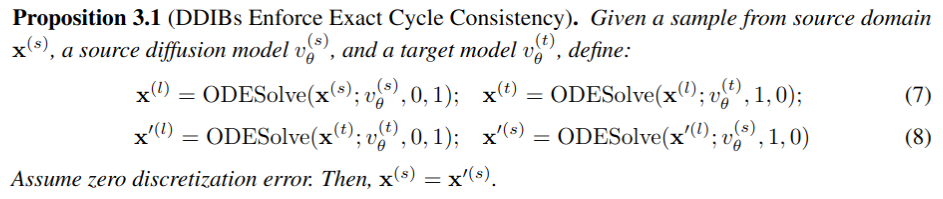

Set timesteps

In [ ]:
num_time_steps = 1000
scheduler.set_timesteps(num_time_steps)
inv_scheduler.set_timesteps(num_time_steps)

In [ ]:
with torch.no_grad():
    latent = image.clone().detach()

    for t in tqdm(inv_scheduler.timesteps, desc="Inverting *back* to latent space..."):
        model_output = unet(latent, t, target_class_idx).sample

        latent = inv_scheduler.step(
            model_output,
            t,
            latent,
        ).prev_sample

In [ ]:
print_grid(tensor_to_PIL(latent, pipeline))

In [ ]:
with torch.no_grad():
    inv_image = latent.clone().detach()

    for t in tqdm(scheduler.timesteps, desc="Regenerating source images..."):
        model_output = unet(inv_image, t, orig_class_idx).sample

        inv_image = scheduler.step(
            model_output,
            t,
            inv_image,
        ).prev_sample

In [ ]:
print_grid(
    [sel_samples[orig_class]["sample_to_show"][sample_sel_idx]]
    + tensor_to_PIL(inv_image, pipeline),
    titles=["Original image"] + target_classes,
)